# Catchment-scale forecasts of veg condition

Using the pre-computed NDVI quarterly climatologies (these have been calculated over all of NSW, but only a subset from the Gwdir catchment is stored on the Sandbox), see if we can predict NDVI one-month in advance.

- Rescaling datasets to 210x210m to speed up testing. 

TODO:
- Run seasonal anomaly using `seasonal_anomalies.ipynb` and compare to anomaly calculation in this script. This will provide a validation of the code here

In [ ]:
# !pip install xarray --upgrade

In [1]:
from datacube import Datacube
import numpy as np
import geopandas as gpd
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from datacube.utils import geometry
from scipy import stats, signal
from datacube.utils.geometry import assign_crs
from statsmodels.tsa.ar_model import AutoReg
from odc.algo import xr_reproject
import sys
import os

sys.path.append('../dea-notebooks/Scripts')
from dea_datahandling import load_ard
from dea_plotting import map_shapefile
from dea_dask import create_local_dask_cluster
from dea_temporal_statistics import fast_completion, smooth
from dea_spatialtools import xr_rasterize

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:39313 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 8 Memory: 61.42 GB


## Analysis Parameters

In [3]:
mean_tifs = 'data/climatologies/mean/'
std_tifs = 'data/climatologies/std/'

shp = 'data/mdb_shps/GWYDIR RIVER.shp'
time = ('2014-01', '2018-12')

In [4]:
gdf = gpd.read_file(shp).to_crs('EPSG:4326')
map_shapefile(gdf, attribute='BNAME')

Label(value='')

Map(center=[-29.939500000000006, 150.02859999999998], controls=(ZoomControl(options=['position', 'zoom_in_text…

## Load data

In [5]:
geom = geometry.Geometry(
        gdf.geometry.values[0].__geo_interface__, geometry.CRS(
            'epsg:4326'))

dc = Datacube(app='whatevrr')

query = {"geopolygon": geom,
         'time': time,
         'measurements':['nbart_red', 'nbart_nir'],
         'output_crs' :'EPSG:3577',
         'resolution' : (-210, 210),
         'resampling' :{"fmask": "nearest", "*": "bilinear"}}

In [6]:
ds = load_ard(dc=dc, 
              dask_chunks={'x':500, 'y':500, 'time':-1},
              products=["ga_ls8c_ard_3"],
              **query)

mask = xr_rasterize(gdf.iloc[[0]], ds)

ds = ds.where(mask).astype('float32')

Finding datasets
    ga_ls8c_ard_3
Applying pixel quality/cloud mask
Returning 897 time steps as a dask array
Rasterizing to match xarray.DataArray dimensions (1089, 1472)


## Calculate NDVI

In [7]:
ds = (ds.nbart_nir - ds.nbart_red) / (ds.nbart_nir + ds.nbart_red)

## Fill gaps and resample to monthly

TODO: switch to `fast_completion` (wrap function inside xr.map_blocks or xr.apply_ufunc)

In [8]:
ndvi_monthly = ds.interpolate_na(dim='time', method='linear').resample(time='1M').mean()#.rolling(time=3, min_periods=3, center=True).mean()

## Load climatologies
Data is a subset over the Gwydir catchment

In [9]:
list_of_mean_tifs = os.listdir(mean_tifs)
list_of_std_tifs = os.listdir(std_tifs)

chunks = {'x':1000, 'y':1000}
# quarterly NDVI mean climatologies
x = []
for tif in list_of_mean_tifs:
    y = assign_crs(xr.open_rasterio(mean_tifs+tif, chunks=chunks))
    y = xr_reproject(y,ds.geobox,"bilinear")
    x.append(y.rename(tif[15:-11]))
    
clim_mean = xr.merge(x).squeeze().drop('band')

# quarterly NDVI std. dev. climatologies
x = []
for tif in list_of_std_tifs:
    y = assign_crs(xr.open_rasterio(std_tifs+tif, chunks=chunks))
    y = xr_reproject(y,ds.geobox,"bilinear")
    x.append(y.rename(tif[14:-11]))
    
clim_std = xr.merge(x).squeeze().drop('band')

## Calculate standardized anomalies

Loop through each year+quarter and substract climatology, then rebuild time-series

In [10]:
# First compute our arrays
clim_std = clim_std.compute()
clim_mean = clim_mean.compute()
ndvi_monthly = ndvi_monthly.compute()

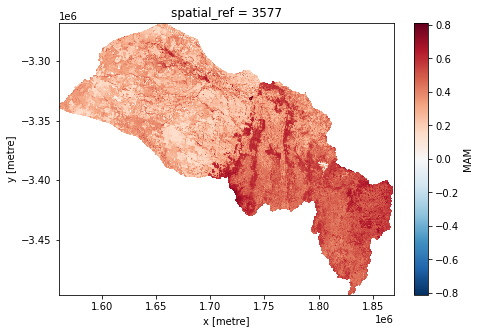

In [11]:
clim_mean.MAM.plot(size=5)

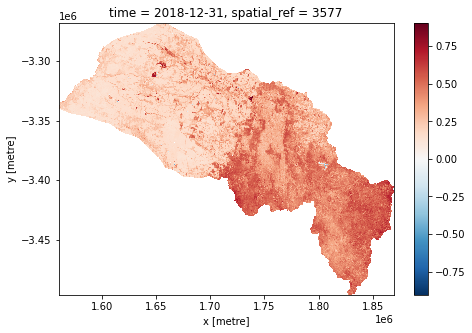

In [13]:
ndvi_monthly.isel(time=59).plot(size=5)

#### TODO: BETTER HANDLE YEARS LOOP...KEEPS GOING THROUGH ENTIRE YEAR EVEN IF THERE'S ONLY A FEW MONTHS FROM THAT YEAR

In [15]:
import warnings
warnings.filterwarnings("ignore")

#define the 3-month intervals
quarter= {'JFM': [1,2,3],
           'FMA': [2,3,4],
           'MAM': [3,4,5],
           'AMJ': [4,5,6],
           'MJJ': [5,6,7],
           'JJA': [6,7,8],
           'JAS': [7,8,9],
           'ASO': [8,9,10],
           'SON': [9,10,11],
           'OND': [10,11,12],
           'NDJ': [11,12,1],
           'DJF': [12,1,2],
                      }
#get the unique years in ds
years = [str(i) for i in np.unique(ndvi_monthly.time.dt.year.values)]

#loop through each 3 month period and calculate the anomaly
z=[]
for year in years:
    for q in quarter:
        months = quarter.get(q)
        if (q == "DJF") or (q == "NDJ"):
            time=(year + "-" + str(months[0]), str(int(year) + 1) + "-" + str(months[2]))
        else:
            time = (year + "-" + str(months[0]), year + "-" + str(months[2]))
        obs=ndvi_monthly.sel(time=slice(time[0], time[1])).mean('time')
        m=clim_mean[q]
        s=clim_std[q]
        anom = (obs - m) / s
        print(year+'_'+q)
        anom.rename(year+'_'+q)
        z.append(anom)

2014_JFM
2014_FMA
2014_MAM
2014_AMJ
2014_MJJ
2014_JJA
2014_JAS
2014_ASO
2014_SON
2014_OND
2014_NDJ
2014_DJF
2015_JFM
2015_FMA
2015_MAM
2015_AMJ
2015_MJJ
2015_JJA
2015_JAS
2015_ASO
2015_SON
2015_OND
2015_NDJ
2015_DJF
2016_JFM
2016_FMA
2016_MAM
2016_AMJ
2016_MJJ
2016_JJA
2016_JAS
2016_ASO
2016_SON
2016_OND
2016_NDJ
2016_DJF
2017_JFM
2017_FMA
2017_MAM
2017_AMJ
2017_MJJ
2017_JJA
2017_JAS
2017_ASO
2017_SON
2017_OND
2017_NDJ
2017_DJF
2018_JFM
2018_FMA
2018_MAM
2018_AMJ
2018_MJJ
2018_JJA
2018_JAS
2018_ASO
2018_SON
2018_OND
2018_NDJ
2018_DJF


#### TODO: auto handle dates

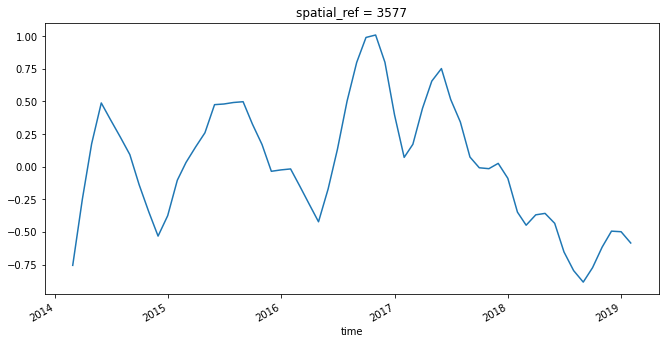

In [20]:
# Build back into time-series
stand_anomalies=xr.concat(z, dim=pd.date_range(start='2/2014', end='2/2019', freq='M')).rename({'concat_dim':'time'})

stand_anomalies.mean(['x','y']).plot(figsize=(11,5))

## Make a forecast

`AutoReg` doesn't like the all-NaN's slices outide the mask extent, run `stand_anomalies.fillna(-999)`

In [29]:
stand_anomalies = stand_anomalies.fillna(-999)

In [31]:
test_length=1
window=20
lags=20

In [43]:
%%time
def xr_autoregress(da, test_length, window, lags):
    #dropna conveneiently with pandas
    da =  da[~np.isnan(da)]
    # split dataset
    train, test = da[1:len(da)-test_length], da[len(da)-test_length:]
    # train autoregression
    model = AutoReg(train, lags=lags)
    model_fit = model.fit()
    coef = model_fit.params

    # walk forward over time steps in test
    history = train[len(train)-window:]
    history = [history[i] for i in range(len(history))]

    predictions = list()
    for t in range(len(test)):
        length = len(history)
        lag = [history[i] for i in range(length-window,length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window-d-1]
        obs = test[t]
        predictions.append(yhat)
        history.append(obs) 
    
    return np.array(predictions).flatten()

predict = xr.apply_ufunc(xr_autoregress,
                      stand_anomalies,#.isel(x=range(700,1000),y=range(600,800)),#.chunk(dict(x=500,y=500,time=-1)),
                      kwargs={'test_length':test_length,'window':window,'lags':window},
                      input_core_dims=[['time']],
                      output_core_dims=[['predictions']], 
                      output_sizes=({'predictions':test_length}),
                      exclude_dims=set(('time',)),
                      vectorize=True,
                      dask="parallelized",
                      output_dtypes=[stand_anomalies.dtype]).compute()

print(predict)

<xarray.DataArray (y: 1089, x: 1472, predictions: 1)>
array([[[-999.],
        [-999.],
        [-999.],
        ...,
        [-999.],
        [-999.],
        [-999.]],

       [[-999.],
        [-999.],
        [-999.],
        ...,
        [-999.],
        [-999.],
        [-999.]],

       [[-999.],
        [-999.],
        [-999.],
        ...,
        [-999.],
        [-999.],
        [-999.]],

       ...,

       [[-999.],
        [-999.],
        [-999.],
        ...,
        [-999.],
        [-999.],
        [-999.]],

       [[-999.],
        [-999.],
        [-999.],
        ...,
        [-999.],
        [-999.],
        [-999.]],

       [[-999.],
        [-999.],
        [-999.],
        ...,
        [-999.],
        [-999.],
        [-999.]]])
Coordinates:
    spatial_ref  int32 3577
  * x            (x) float64 1.56e+06 1.56e+06 1.561e+06 ... 1.869e+06 1.869e+06
  * y            (y) float64 -3.268e+06 -3.268e+06 ... -3.496e+06 -3.496e+06
Dimensions without coordinates: 

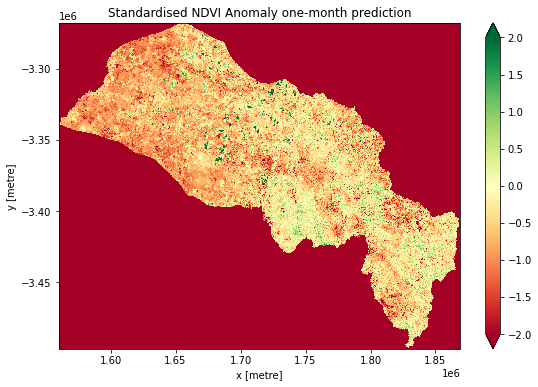

In [55]:
predict.plot(size=6, vmin=-2.0, vmax=2, cmap='RdYlGn')
plt.title('Standardised NDVI Anomaly one-month prediction');

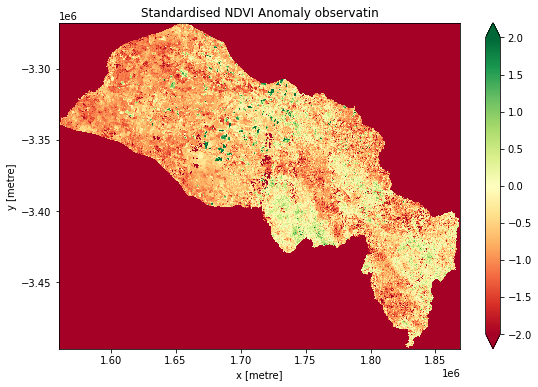

In [56]:
stand_anomalies.isel(time=-1).plot(size=6, vmin=-2.0, vmax=2, cmap='RdYlGn')
plt.title('Standardised NDVI Anomaly observation');

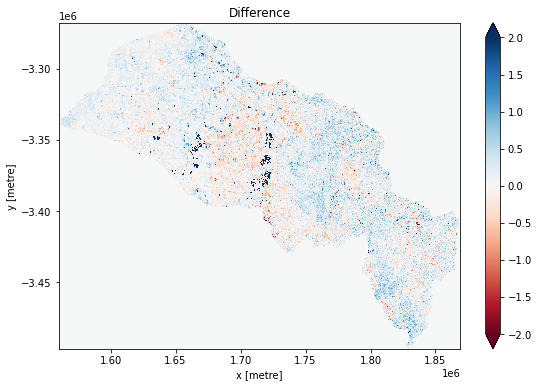

In [57]:
diff = predict - stand_anomalies.isel(time=-1)

diff.plot(size=6, vmin=-2.0, vmax=2, cmap='RdBu')
plt.title('Difference');

In [58]:
diff.mean(['x','y'])

<xarray.DataArray (predictions: 1)>
array([6.33193223])
Coordinates:
    spatial_ref  int32 3577
    time         datetime64[ns] 2019-01-31
Dimensions without coordinates: predictions